# **🔹 GNN を用いた分子予測モデルの全コードまとめ**  

このコードは、**グラフニューラルネットワーク（GNN）を用いて分子の特性（HOMO-LUMO ギャップ）を予測する** ためのものです。  
以下の手順でデータの前処理からモデルの学習・評価・可視化までを行っています。

---

## **📌 1. 環境の準備**
```python
!pip install torch_geometric rdkit
```
- **`torch_geometric`**: グラフニューラルネットワーク（GNN）のライブラリ  
- **`rdkit`**: 分子構造の処理ライブラリ  

---

## **📌 2. Google Drive からデータを読み込む**
```python
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
property_df = pd.read_csv('/content/drive/My Drive/day6/property_df.csv')
print(property_df.head())  # データ確認
```
- **Google Drive をマウントしてデータ（CSV）を取得**  
- **`pandas` を使ってデータを `DataFrame` として読み込む**  

---

## **📌 3. 分子データのグラフ化**
```python
import torch
import torch_geometric
from rdkit import Chem
from torch_geometric.data import Data, InMemoryDataset
```
- **PyTorch** と **PyTorch Geometric** を使用  
- **RDKit** を使って分子の `SMILES` 文字列を解析  

### **📍 データセットの定義**
```python
class MoleculesDataset(InMemoryDataset):
    def __init__(self, smiles, ys, transform=None, pre_transform=None):
        super(MoleculesDataset, self).__init__(".", transform, pre_transform)

        boolean = {True: 1, False: 0}
        hybridization = {"S": 0.5, "SP": 1, "SP2": 2, "SP3": 3, "SP3D": 3.5}
        bondtype = {"SINGLE": 1, "DOUBLE": 2, "AROMATIC": 1.5, "TRIPLE": 3}

        self.datas = []
        for smile, y in zip(smiles, ys):
            mol = Chem.MolFromSmiles(smile)

            embeddings = []
            for atom in mol.GetAtoms():
                a = [atom.GetAtomicNum(), atom.GetMass(), hybridization[str(atom.GetHybridization())], boolean[atom.IsInRing()], boolean[atom.GetIsAromatic()]]
                embeddings.append(a)
            embeddings = torch.tensor(embeddings, dtype=torch.float)

            edges = []
            edge_attr = []
            for bond in mol.GetBonds():
                edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
                edge_attr.append([bondtype[str(bond.GetBondType())], boolean[bond.GetIsAromatic()], boolean[bond.IsInRing()]])
            edges = torch.tensor(edges, dtype=torch.long).T
            edge_attr = torch.tensor(edge_attr, dtype=torch.float)

            y = torch.tensor(y, dtype=torch.float).unsqueeze(0)
            data = Data(x=embeddings, edge_index=edges, y=y, edge_attr=edge_attr)
            self.datas.append(data)

    def len(self):
        return len(self.datas)

    def get(self, idx):
        return self.datas[idx]
```
- **分子構造を GNN 用のグラフデータに変換**  
- **原子の特徴量・結合の特徴量を `torch.tensor` に変換**  

---

## **📌 4. データの前処理**
```python
import numpy as np

df = property_df
df_numeric = df.select_dtypes(include=[np.number])
df_cla = pd.DataFrame(np.where(df_numeric > df_numeric.mean(), 1, 0), columns=df_numeric.columns)
df_cla = pd.concat([df_cla, df.select_dtypes(exclude=[np.number])], axis=1)

smiles = list(df["Open Babel SMILES"])
ys = list(df_cla["HOMO-LUMO gap"])

max_nodes = 128
dataset = MoleculesDataset(smiles, ys, transform=torch_geometric.transforms.ToDense(max_nodes))
```
- **数値データを 0/1 に変換し、学習しやすい形に**  
- **分子の `SMILES` 文字列を `MoleculesDataset` に変換**  

---

## **📌 5. データの分割**
```python
dataset = dataset.shuffle()
n = (len(dataset) + 9) // 10
test_dataset = dataset[:n]
val_dataset = dataset[n:2 * n]
train_dataset = dataset[2 * n:]

test_loader = torch_geometric.loader.DenseDataLoader(test_dataset, batch_size=32)
val_loader = torch_geometric.loader.DenseDataLoader(val_dataset, batch_size=32)
train_loader = torch_geometric.loader.DenseDataLoader(train_dataset, batch_size=32)
```
- **データセットを `train/val/test` に分割**  
- **`DenseDataLoader` を使用し、GNN の入力として準備**  

---

## **📌 6. GNN モデルの定義**
```python
from torch_geometric.nn import DenseGCNConv as GCNConv, dense_diff_pool

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, normalize=False):
        super(GNN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels, normalize))
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

    def forward(self, x, adj, mask=None):
        for conv in self.convs:
            x = conv(x, adj, mask)
            x = torch.nn.functional.relu(x)
        return x
```
- **GNN モデル（GCNConv）を使用して特徴抽出**  
- **活性化関数 `ReLU` を適用**  

---

## **📌 7. 訓練・評価関数**
```python
def train(epoch):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output, _, _ = model(data.x, data.adj.sum(axis=3), data.mask)
        loss = torch.nn.functional.nll_loss(output, data.y.long().view(-1))
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.adj.sum(axis=3), data.mask)[0].max(dim=1)[1]
        correct += pred.eq(data.y.view(-1)).sum().item()
    return correct / len(loader.dataset)
```
- **学習 (`train`)**: 損失計算・バックプロパゲーション  
- **評価 (`test`)**: 正解率を計算  

---

## **📌 8. 学習と可視化**
```python
import matplotlib.pyplot as plt

model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
max_epoch = 10
best_val_acc = 0
loss_hist, val_hist, test_hist = [], [], []

for epoch in range(1, max_epoch):
    train_loss = train(epoch)
    val_acc = test(val_loader)
    test_acc = test(test_loader)
    loss_hist.append(train_loss)
    val_hist.append(val_acc)
    test_hist.append(test_acc)

plt.plot(loss_hist, label="Train Loss")
plt.legend()
plt.show()

plt.plot(val_hist, label="Val Acc")
plt.plot(test_hist, label="Test Acc")
plt.legend()
plt.show()
```
- **学習を 10 エポック実行し、損失と精度を記録**  
- **Matplotlib で学習曲線を可視化**  

---

# **✅ まとめ**
このコードは、**分子のグラフデータを GNN で処理し、HOMO-LUMO ギャップの予測を行う** ものです。  
- **データ前処理（分子の特徴量抽出）**
- **GNN の定義**
- **学習・評価**
- **学習曲線の可視化**

💡 **分子の特性を予測する GNN モデルの基礎が実装されたコード！** 🚀

In [ ]:
# Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

# pandasを使ってCSVデータを読み込み
import pandas as pd
property_df = pd.read_csv('/content/drive/My Drive/day6/property_df.csv')

# データを表示 (オプション)
print(property_df.head())

Mounted at /content/drive
       Open Babel SMILES  HOMO-LUMO gap  Dipole moment  \
0     OC(=N)Nc1cccc(c1)C          5.608           1.87   
1      CN(CCc1ccc(o1)C)C          6.142           0.54   
2           Cc1cccc(n1)C          6.101           1.42   
3  OC(=O)Cc1ccc(c(c1)O)O          5.578           4.46   
4   OCc1ccc(cc1N(=O)=O)N          3.663           5.53   

   Molecular refractivity  Melting point  
0                   44.01         128.68  
1                   45.96          11.86  
2                   34.17          27.50  
3                   42.03         165.60  
4                   45.80         115.73  


このコードは、Google Colab上でGoogle Driveをマウントし、Google Drive内に保存されたCSVファイルをpandasを使って読み込む処理を行います。  

### **コード解説**
---

#### **1. Google Driveをマウント**
```python
from google.colab import drive
drive.mount('/content/drive')
```
- `from google.colab import drive`  
  → Google Colab専用の`drive`ライブラリをインポートします。  
- `drive.mount('/content/drive')`  
  → Google Driveを`/content/drive`にマウントし、Google Drive内のファイルにアクセスできるようにします。  
  → 実行すると認証が求められるので、認証コードを入力するとGoogle DriveがColabに接続されます。  

---

#### **2. pandasを使ってCSVデータを読み込み**
```python
import pandas as pd
property_df = pd.read_csv('/content/drive/My Drive/day6/property_df.csv')
```
- `import pandas as pd`  
  → データ分析ライブラリ`pandas`をインポートします。  
- `pd.read_csv('/content/drive/My Drive/day6/property_df.csv')`  
  → Google Drive内の`My Drive/day6/`フォルダにある`property_df.csv`というCSVファイルを読み込みます。  
  → 読み込んだデータを`property_df`という変数に格納します。  

⚠ **注意点**:
- Google Drive内のパスは`My Drive`を含める必要があります（`/content/drive/My Drive/`）。
- `day6`というフォルダの中に`property_df.csv`があることを前提としています。

---

#### **3. データを表示（オプション）**
```python
print(property_df.head())
```
- `property_df.head()`  
  → 読み込んだデータの最初の5行を表示します（デフォルトで5行）。  
- `print()`を使うことで明示的に表示しますが、Colabでは`property_df.head()`だけでも出力されます。  

---

### **まとめ**
このコードを実行すると、Google Drive内に保存されたCSVファイルを読み込み、データの先頭部分を表示できます。Google Drive上のデータをColabで扱うときによく使う基本的な手順です。

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.8 MB/s eta 0:00:00


このコードは、Pythonのパッケージ管理システム`pip`を使って、`torch_geometric`ライブラリをインストールするためのものです。  

### **コード解説**
```python
!pip install torch_geometric
```
- `!`（エクスクラメーションマーク）：  
  → Google ColabやJupyter Notebookでは、`!` をつけることでシェルコマンド（ターミナルで実行できるコマンド）を実行できます。  
- `pip install torch_geometric`：  
  → `pip`（Pythonのパッケージ管理ツール）を使って、`torch_geometric`ライブラリをインストールします。  

### **`torch_geometric`とは？**
- `torch_geometric` は、**PyTorchを用いたグラフニューラルネットワーク（GNN: Graph Neural Networks）** のライブラリです。
- **グラフ構造のデータ**（例：ソーシャルネットワーク、分子構造、推薦システムのデータ）を扱うためのモデルを簡単に実装できます。
- GNNの一般的な手法（GCN, GAT, GraphSAGEなど）が含まれています。

### **注意点**
- `torch_geometric`を使用するには、**PyTorch (`torch`) やその他の関連ライブラリ** (`torch_sparse`, `torch_scatter`, `torch_cluster`, `torch_spline_conv`) も必要です。
- 通常は、以下のように推奨される手順でインストールします：
  ```python
  !pip install torch torchvision torchaudio  # まずPyTorchをインストール（Colabの場合は不要なことも）
  !pip install torch_geometric
  !pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)").html
  ```
  - `torch`, `torchvision`, `torchaudio`：PyTorch本体と関連ライブラリ
  - `torch_scatter`, `torch_sparse`, `torch_cluster`, `torch_spline_conv`：`torch_geometric`の依存ライブラリ
  - `-f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)").html`  
    → PyTorchのバージョンに適したホイールファイル（`.whl`）をダウンロードするためのオプション

### **まとめ**
このコマンドを実行すると、`torch_geometric`ライブラリがインストールされ、**グラフデータを扱うニューラルネットワークの構築** ができるようになります。GNNを使った機械学習に興味がある場合には重要なライブラリです。

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 45.3 MB/s eta 0:00:00


このコードは、`pip`を使って**RDKit**という化学情報処理ライブラリをインストールするためのものです。  

---

### **コード解説**
```python
!pip install rdkit
```
- `!`（エクスクラメーションマーク）：  
  → Google ColabやJupyter Notebookでは、`!` をつけることでシェルコマンド（ターミナルのコマンド）を実行できます。  
- `pip install rdkit`：  
  → `pip`を使用して、**RDKit**（化学構造の解析・操作のためのライブラリ）をインストールします。  

---

### **RDKitとは？**
- **化学情報処理（ChemInformatics）** のためのオープンソースライブラリ
- **化学構造の操作・解析・可視化** が可能
- 一般的な用途：
  - **分子の描画・可視化**
  - **SMILES・InChI 変換**（分子をテキスト形式で表現）
  - **分子の類似度計算**
  - **物理化学的性質の予測**
  - **構造検索**
  - **分子の3D構造生成**
  
---

### **使用例**
#### **1. SMILES（分子のテキスト表現）から分子構造を表示**
```python
from rdkit import Chem
from rdkit.Chem import Draw

# SMILES 文字列を分子構造に変換
mol = Chem.MolFromSmiles('CCO')  # エタノールのSMILES表現

# 分子構造を描画
Draw.MolToImage(mol)
```
✅ `CCO` はエタノール（C₂H₆O）のSMILES表現。

---

#### **2. 分子の物理化学的性質を計算**
```python
from rdkit.Chem import Descriptors

mol = Chem.MolFromSmiles('CCO')  # エタノール
mw = Descriptors.MolWt(mol)  # 分子量
logp = Descriptors.MolLogP(mol)  # 疎水性（logP）

print(f"分子量: {mw}, LogP: {logp}")
```
✅ 分子量やlogP（水と油の分配係数）を計算できます。

---

### **注意点**
- **Google Colabでは、通常`rdkit`は`conda`経由でインストールするのが一般的**  
  `pip install rdkit` ではなく、以下のようにする：
  ```python
  !conda install -c conda-forge rdkit -y
  ```
  - `-c conda-forge` は `conda-forge` チャネルからインストールする指定
  - `-y` は確認なしでインストールを進めるオプション
- **ローカル環境（Anaconda）では、`conda`でのインストールが推奨**
  ```bash
  conda install -c conda-forge rdkit
  ```

---

### **まとめ**
- `rdkit` は **化学構造の解析・可視化・予測** に使われるライブラリ
- `!pip install rdkit` は `rdkit` をインストールするコマンド
- Google Colab では **`conda`経由のインストール** の方が推奨されることが多い
- 分子構造の描画や物理化学的性質の予測など、様々な用途に利用可能

In [ ]:
import torch
import torch_geometric
from rdkit import Chem
from torch_geometric.data import Data, InMemoryDataset

class MoleculesDataset(InMemoryDataset):
    def __init__(self, smiles, ys, transform=None, pre_transform=None):
        super(MoleculesDataset, self).__init__(".", transform, pre_transform)

        boolean = {True: 1, False: 0}
        hybridization = {"S": 0.5, "SP": 1, "SP2": 2, "SP3": 3, "SP3D": 3.5}
        bondtype = {"SINGLE": 1, "DOUBLE": 2, "AROMATIC": 1.5, "TRIPLE": 3}

        self.datas = []
        for smile, y in zip(smiles, ys):
            mol = Chem.MolFromSmiles(smile)

            embeddings = []
            for atom in mol.GetAtoms():
                a = []
                a.append(atom.GetAtomicNum())
                a.append(atom.GetMass())
                a.append(hybridization[str(atom.GetHybridization())])
                a.append(boolean[atom.IsInRing()])
                a.append(boolean[atom.GetIsAromatic()])
                embeddings.append(a)
            embeddings = torch.tensor(embeddings, dtype=torch.float)

            edges = []
            edge_attr = []
            for bond in mol.GetBonds():
                edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
                b = []
                b.append(bondtype[str(bond.GetBondType())])
                b.append(boolean[bond.GetIsAromatic()])
                b.append(boolean[bond.IsInRing()])
                edge_attr.append(b)
            edges = torch.tensor(edges, dtype=torch.long).T
            edge_attr = torch.tensor(edge_attr, dtype=torch.float)

            y = torch.tensor(y, dtype=torch.float).unsqueeze(0)

            data = Data(x=embeddings, edge_index=edges, y=y, edge_attr=edge_attr)
            self.datas.append(data)

    def len(self):
        return len(self.datas)

    def get(self, idx):
        return self.datas[idx]

smiles = list(property_df["Open Babel SMILES"])
ys = list(property_df["HOMO-LUMO gap"])
max_nodes = 128
dataset = MoleculesDataset(smiles, ys, transform=torch_geometric.transforms.ToDense(max_nodes))

このコードは、**分子構造データをグラフデータとして表現し、PyTorch Geometric を用いて分子のグラフデータセットを作成する** ものです。  

---

## **コードの概要**
- **`RDKit`** を使って **SMILES（分子の文字列表現）から分子構造を取得**
- **各原子の特徴量（埋め込みベクトル）と結合情報を抽出**
- **PyTorch Geometric の `Data` クラスを使用してグラフデータを作成**
- **`MoleculesDataset` クラスを定義し、複数の分子データを保持するデータセットを作成**
- **最大ノード数 `max_nodes=128` に変換してデータを格納**

---

## **コードの詳細な解説**
### **1. 必要なライブラリをインポート**
```python
import torch
import torch_geometric
from rdkit import Chem
from torch_geometric.data import Data, InMemoryDataset
```
- `torch`: PyTorch の基本ライブラリ
- `torch_geometric`: グラフニューラルネットワーク（GNN）のためのライブラリ
- `rdkit`: 化学情報処理ライブラリ
- `Data`: PyTorch Geometric でグラフデータを表現するクラス
- `InMemoryDataset`: メモリ内で管理できるデータセットクラス

---

### **2. `MoleculesDataset` クラス（カスタムデータセットの作成）**
```python
class MoleculesDataset(InMemoryDataset):
    def __init__(self, smiles, ys, transform=None, pre_transform=None):
        super(MoleculesDataset, self).__init__(".", transform, pre_transform)
```
- `smiles`: 分子のSMILES表記のリスト（`property_df["Open Babel SMILES"]`）
- `ys`: 目的変数（分子の物性値 `property_df["HOMO-LUMO gap"]`）
- `transform`: グラフデータの変換用（今回は `ToDense` を使用）
- `pre_transform`: データを前処理するためのオプション

---

### **3. 分子の特徴量を定義**
```python
boolean = {True: 1, False: 0}
hybridization = {"S": 0.5, "SP": 1, "SP2": 2, "SP3": 3, "SP3D": 3.5}
bondtype = {"SINGLE": 1, "DOUBLE": 2, "AROMATIC": 1.5, "TRIPLE": 3}
```
- `boolean`: **真偽値（リング構造や芳香族性）の変換**
- `hybridization`: **原子の混成軌道の数値化**
- `bondtype`: **結合の種類を数値化**

---

### **4. 各分子データの処理**
```python
self.datas = []
for smile, y in zip(smiles, ys):
    mol = Chem.MolFromSmiles(smile)
```
- `self.datas = []`: **グラフデータを格納するリスト**
- `Chem.MolFromSmiles(smile)`: **SMILES 文字列から分子構造を取得**

---

### **5. 各原子の特徴量を抽出**
```python
embeddings = []
for atom in mol.GetAtoms():
    a = []
    a.append(atom.GetAtomicNum())  # 原子番号
    a.append(atom.GetMass())  # 原子の質量
    a.append(hybridization[str(atom.GetHybridization())])  # 混成軌道
    a.append(boolean[atom.IsInRing()])  # リング構造かどうか
    a.append(boolean[atom.GetIsAromatic()])  # 芳香族性
    embeddings.append(a)
embeddings = torch.tensor(embeddings, dtype=torch.float)
```
- `GetAtomicNum()`: **原子番号（例：炭素=6, 酸素=8）**
- `GetMass()`: **原子の質量**
- `GetHybridization()`: **混成軌道（sp, sp2, sp3 など）**
- `IsInRing()`: **その原子が環状構造の一部かどうか**
- `GetIsAromatic()`: **芳香族（ベンゼン環など）かどうか**

👉 これらの情報を `torch.tensor()` でテンソル化し、**原子特徴量行列 `x`** を作成。

---

### **6. 結合情報（エッジ情報）の取得**
```python
edges = []
edge_attr = []
for bond in mol.GetBonds():
    edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    b = []
    b.append(bondtype[str(bond.GetBondType())])  # 結合の種類
    b.append(boolean[bond.GetIsAromatic()])  # 芳香族性
    b.append(boolean[bond.IsInRing()])  # 環状構造か
    edge_attr.append(b)
edges = torch.tensor(edges, dtype=torch.long).T
edge_attr = torch.tensor(edge_attr, dtype=torch.float)
```
- `GetBonds()`: **分子内の結合を取得**
- `GetBeginAtomIdx(), GetEndAtomIdx()`: **結合している2つの原子のインデックス**
- `bondtype[str(bond.GetBondType())]`: **単結合、二重結合などの数値変換**
- `bond.GetIsAromatic()`: **結合が芳香族性かどうか**
- `bond.IsInRing()`: **結合が環状構造の一部かどうか**

👉 これらを **エッジリスト `edge_index` とエッジ特徴量 `edge_attr`** に変換。

---

### **7. PyTorch Geometric の `Data` オブジェクトを作成**
```python
y = torch.tensor(y, dtype=torch.float).unsqueeze(0)

data = Data(x=embeddings, edge_index=edges, y=y, edge_attr=edge_attr)
self.datas.append(data)
```
- `x`: **ノード特徴量（各原子の情報）**
- `edge_index`: **エッジ情報（結合情報）**
- `edge_attr`: **エッジの特徴量（結合の種類・環状構造・芳香族性）**
- `y`: **目的変数（物性値）**

👉 `Data` オブジェクトとして**グラフデータを作成**し、リスト `self.datas` に保存。

---

### **8. データセットのメソッド**
```python
def len(self):
    return len(self.datas)

def get(self, idx):
    return self.datas[idx]
```
- `len()`: **データセットのサイズを取得**
- `get(idx)`: **指定したインデックスのデータを取得**

---

### **9. データセットの作成**
```python
smiles = list(property_df["Open Babel SMILES"])
ys = list(property_df["HOMO-LUMO gap"])
max_nodes = 128
dataset = MoleculesDataset(smiles, ys, transform=torch_geometric.transforms.ToDense(max_nodes))
```
- `property_df["Open Babel SMILES"]`: **SMILESデータ**
- `property_df["HOMO-LUMO gap"]`: **目的変数（物性値）**
- `ToDense(max_nodes)`: **グラフを固定サイズ `128` に変換**

---

## **まとめ**
- `RDKit` で **SMILES から分子情報を取得**
- PyTorch Geometric の `Data` クラスで **分子をグラフとして表現**
- `MoleculesDataset` で **複数の分子データをデータセット化**
- **分子特徴量（原子の種類・結合の種類など）を学習可能な形式に変換**

👉 **分子グラフニューラルネットワーク（GNN）での学習準備が整った！** 🚀

In [ ]:
dataset = dataset.shuffle()
n = (len(dataset) + 9) // 10
test_dataset = dataset[:n]
val_dataset = dataset[n:2 * n]
train_dataset = dataset[2 * n:]
test_loader = torch_geometric.loader.DenseDataLoader(test_dataset, batch_size=32)
val_loader = torch_geometric.loader.DenseDataLoader(val_dataset, batch_size=32)
train_loader = torch_geometric.loader.DenseDataLoader(train_dataset, batch_size=32)

このコードは、**分子グラフデータセットをシャッフルし、トレーニング・検証・テスト用に分割し、それぞれをバッチ処理するためのデータローダーを作成する** ものです。  

---

## **コードの概要**
1. **データセットをシャッフル**
2. **データを 10:10:80 の割合でテスト・検証・トレーニングに分割**
3. **`DenseDataLoader` を使ってデータローダーを作成（バッチサイズ=32）**

---

## **コードの詳細な解説**
### **1. データセットをシャッフル**
```python
dataset = dataset.shuffle()
```
- `shuffle()` を使うことで、**データセットの順序をランダムに並び替え** ます。
- これにより、トレーニング・検証・テストセットの分割が偏らないようになります。

---

### **2. データセットを 10:10:80 に分割**
```python
n = (len(dataset) + 9) // 10
test_dataset = dataset[:n]
val_dataset = dataset[n:2 * n]
train_dataset = dataset[2 * n:]
```
#### **分割の計算**
- `n = (len(dataset) + 9) // 10`
  - `len(dataset)` は **データセットの総数**
  - `+9` は **切り上げを行うため**（小さいデータセットでも適切に分割するため）
  - `// 10` で **データセットを約10等分** し、`n` は **全体の 10% のデータ数** となる

#### **データセットの分割**
- `test_dataset = dataset[:n]` → **最初の 10% をテスト用**
- `val_dataset = dataset[n:2 * n]` → **次の 10% を検証用**
- `train_dataset = dataset[2 * n:]` → **残り 80% をトレーニング用**

---

### **3. バッチ処理用のデータローダーを作成**
```python
test_loader = torch_geometric.loader.DenseDataLoader(test_dataset, batch_size=32)
val_loader = torch_geometric.loader.DenseDataLoader(val_dataset, batch_size=32)
train_loader = torch_geometric.loader.DenseDataLoader(train_dataset, batch_size=32)
```
- `DenseDataLoader` は **グラフデータを固定サイズのバッチに分割して処理するデータローダー**
- 各データローダーの役割：
  - `test_loader`：テストデータ用（評価時に使用）
  - `val_loader`：検証データ用（モデルのハイパーパラメータ調整に使用）
  - `train_loader`：トレーニングデータ用（モデルの学習に使用）
- `batch_size=32`：
  - 1回のデータローディングで **最大32個の分子グラフをまとめて処理**
  - 大規模データの場合、バッチサイズを調整することで **メモリ消費を最適化**

---

## **まとめ**
- **データセットをシャッフル**
- **10:10:80 の割合でテスト・検証・トレーニング用に分割**
- **バッチサイズ32で `DenseDataLoader` を使用し、効率的にデータを処理**

👉 **このコードにより、GNN（グラフニューラルネットワーク）の学習がスムーズに行える準備が整った！** 🚀

In [ ]:
from torch_geometric.nn import DenseGCNConv as GCNConv, dense_diff_pool
from math import ceil

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 normalize=False, lin=True):
        super(GNN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels, normalize))
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        #self.convs.append(GCNConv(hidden_channels, hidden_channels, normalize))
        #self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        #self.convs.append(GCNConv(hidden_channels, out_channels, normalize))
        #self.bns.append(torch.nn.BatchNorm1d(out_channels))

    def forward(self, x, adj, mask=None):
        batch_size, num_nodes, in_channels = x.size()
        for step in range(len(self.convs)):
            x = self.convs[step](x, adj, mask)
            x = torch.nn.functional.relu(x)
        return x


class Net(torch.nn.Module):
    def __init__(self, regr=False):
        super(Net, self).__init__()

        num_nodes = ceil(0.25 * max_nodes)
        self.gnn1_pool = GNN(dataset.num_features, 64, num_nodes)
        self.gnn1_embed = GNN(dataset.num_features, 64, 64)
        num_nodes = ceil(0.25 * num_nodes)
        self.gnn2_pool = GNN(64, 64, num_nodes)
        self.gnn2_embed = GNN(64, 64, 64, lin=False)
        self.gnn3_embed = GNN(64, 64, 64, lin=False)
        self.lin1 = torch.nn.Linear(64, 64)
        self.lin2 = torch.nn.Linear(64, dataset.num_classes)
        self.regr = regr

    def forward(self, x, adj, mask=None):
        s = self.gnn1_pool(x, adj, mask)
        x = self.gnn1_embed(x, adj, mask)
        x, adj, l1, e1 = torch_geometric.nn.dense_diff_pool(x, adj, s, mask)
        s = self.gnn2_pool(x, adj)
        x = self.gnn2_embed(x, adj)
        x, adj, l2, e2 = torch_geometric.nn.dense_diff_pool(x, adj, s)
        x = self.gnn3_embed(x, adj)
        x = x.mean(dim=1)
        x = torch.nn.functional.relu(self.lin1(x))
        x = self.lin2(x)
        if self.regr:
            return x, l1 + l2, e1 + e2
        else:
            return torch.nn.functional.log_softmax(x, dim=-1), l1 + l2, e1 + e2

このコードは、**グラフニューラルネットワーク (GNN) を用いたグラフ分類・回帰のモデル** を実装しています。  
特に、**Dense GCN**（密なグラフ畳み込みネットワーク）と **dense_diff_pool（グラフプーリング）** を用いて、グラフデータの特徴を抽出・圧縮し、最終的な出力を得る仕組みになっています。

---

# **コードの概要**
1. **`GNN` クラス**（グラフニューラルネットワークの基本構造）
2. **`Net` クラス**（全体のネットワーク構造）
   - **グラフプーリング** (`dense_diff_pool`) を用いた階層的な特徴抽出
   - **最終的な分類 or 回帰**
3. **順伝播 (`forward`) の流れ**

---

# **コードの詳細な解説**
## **1. `GNN` クラス**
### **目的**
`GNN` クラスは、**グラフ畳み込み（GCNConv）を用いた特徴抽出の基本モジュール** です。

### **コードの解説**
```python
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 normalize=False, lin=True):
        super(GNN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        
        # 最初のGCN層
        self.convs.append(GCNConv(in_channels, hidden_channels, normalize))
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        # 追加のGCN層（コメントアウト）
        # self.convs.append(GCNConv(hidden_channels, hidden_channels, normalize))
        # self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        # self.convs.append(GCNConv(hidden_channels, out_channels, normalize))
        # self.bns.append(torch.nn.BatchNorm1d(out_channels))
```
- `GCNConv(in_channels, hidden_channels, normalize)`  
  - **グラフ畳み込みニューラルネットワーク (GCN) を1層追加**
- `BatchNorm1d(hidden_channels)`  
  - **バッチ正規化（学習の安定化・収束の高速化）**
- 他の GCN 層はコメントアウトされており、1層のみが有効

---

### **順伝播の処理**
```python
def forward(self, x, adj, mask=None):
    batch_size, num_nodes, in_channels = x.size()
    for step in range(len(self.convs)):
        x = self.convs[step](x, adj, mask)  # GCNによる特徴抽出
        x = torch.nn.functional.relu(x)  # ReLU活性化関数
    return x
```
- `GCNConv` を適用して隣接行列 `adj` を考慮したグラフ畳み込み
- `ReLU` を適用して非線形変換

---

## **2. `Net` クラス**
### **目的**
- **グラフプーリング (`dense_diff_pool`) を利用して、グラフの構造を階層的に圧縮**
- **分類 or 回帰を行う最終出力を得る**

---

### **ネットワークの構造**
```python
class Net(torch.nn.Module):
    def __init__(self, regr=False):
        super(Net, self).__init__()

        num_nodes = ceil(0.25 * max_nodes)  # 初回のプーリング後のノード数

        # 第一段階の GNN
        self.gnn1_pool = GNN(dataset.num_features, 64, num_nodes)  # プーリング用
        self.gnn1_embed = GNN(dataset.num_features, 64, 64)  # 埋め込み用

        num_nodes = ceil(0.25 * num_nodes)  # 第二段階のプーリング後のノード数

        # 第二段階の GNN
        self.gnn2_pool = GNN(64, 64, num_nodes)  # プーリング用
        self.gnn2_embed = GNN(64, 64, 64, lin=False)  # 埋め込み用

        # 第三段階の GNN（プーリングなし）
        self.gnn3_embed = GNN(64, 64, 64, lin=False)

        # 全結合層
        self.lin1 = torch.nn.Linear(64, 64)
        self.lin2 = torch.nn.Linear(64, dataset.num_classes)
        self.regr = regr  # 回帰問題かどうかのフラグ
```
- `gnn1_pool, gnn1_embed`  
  - **第一層の GNN**
  - `gnn1_pool` はグラフプーリング用
  - `gnn1_embed` は特徴抽出用
- `gnn2_pool, gnn2_embed`  
  - **第二層の GNN**
  - `gnn2_pool` でさらにグラフを圧縮
  - `gnn2_embed` で特徴抽出
- `gnn3_embed`  
  - **第三層の GNN**（プーリングなし）
- `lin1, lin2`  
  - **全結合層 (MLP) で最終分類**

---

### **順伝播の処理**
```python
def forward(self, x, adj, mask=None):
    s = self.gnn1_pool(x, adj, mask)  # プーリング行列 s を作成
    x = self.gnn1_embed(x, adj, mask)  # 特徴抽出
    x, adj, l1, e1 = torch_geometric.nn.dense_diff_pool(x, adj, s, mask)  # プーリング適用

    s = self.gnn2_pool(x, adj)  # 第二層のプーリング行列
    x = self.gnn2_embed(x, adj)  # 特徴抽出
    x, adj, l2, e2 = torch_geometric.nn.dense_diff_pool(x, adj, s)  # 再度プーリング

    x = self.gnn3_embed(x, adj)  # 第三層の GNN で特徴抽出
    x = x.mean(dim=1)  # グラフ全体の平均をとる

    x = torch.nn.functional.relu(self.lin1(x))  # MLP の第一層
    x = self.lin2(x)  # 最終出力

    if self.regr:  # 回帰の場合
        return x, l1 + l2, e1 + e2
    else:  # 分類の場合
        return torch.nn.functional.log_softmax(x, dim=-1), l1 + l2, e1 + e2
```
- **`dense_diff_pool(x, adj, s)`**
  - **プーリングを適用し、グラフのサイズを圧縮**
  - `x`（特徴行列）と `adj`（隣接行列）を更新
  - `l1, l2` はプーリングの損失項
  - `e1, e2` はエントロピー損失（正則化）
- **`x.mean(dim=1)`**
  - 各グラフのノード特徴の平均を計算
- **最終分類 or 回帰**
  - `log_softmax(x, dim=-1)`（分類用）
  - `return x, l1 + l2, e1 + e2`（回帰用）

---

# **まとめ**
✅ **GNNクラス** → **GCNConv を使った基本的なグラフ畳み込み**  
✅ **Netクラス** → **`dense_diff_pool` による階層的なグラフ圧縮を適用**  
✅ **出力は分類 or 回帰が選択可能**  

**このモデルは、分子データの分類・回帰に適したグラフニューラルネットワーク (GNN) を構築するためのもの！** 🚀

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

このコードは、**PyTorch で GPU（CUDA）が利用可能かどうかを判定し、適切なデバイスを選択する処理** です。

---

### **コードの解説**
```python
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
```
#### **1. `torch.cuda.is_available()`**
- CUDA（GPU計算ライブラリ）が **利用可能かどうかを判定** する関数
- `True` なら **GPU が利用可能**
- `False` なら **GPU が使えない（CPU のみ）**

#### **2. `torch.device('cuda' if torch.cuda.is_available() else 'cpu')`**
- **`cuda`**（GPUが利用可能な場合）
- **`cpu`**（GPUが利用不可の場合）
- これにより、GPUが使える環境では **自動的に CUDA に設定される**

#### **3. `device` を出力**
- `device` 変数には、 `"cuda"` または `"cpu"` のどちらかが格納されている。
- `device` を出力すると、どちらが選ばれたかが分かる。

---

### **実行結果の例**
**✅ GPUが利用可能な場合**
```python
torch.device('cuda')
```
**✅ GPUが利用不可（CPUのみ）の場合**
```python
torch.device('cpu')
```

---

### **実際の用途**
- **モデルやデータを適切なデバイスに転送する**
```python
model.to(device)  # モデルをGPUまたはCPUに転送
data = data.to(device)  # データをGPUまたはCPUに転送
```
- **GPU があるなら GPU、なければ CPU で処理を実行** することで、汎用性の高いコードを書くことができる！

---

💡 **つまり、このコードは "GPUを使えるならGPU、使えないならCPUを選ぶ" ための処理！** 🚀

In [ ]:
def train(epoch):
    model.train()
    loss_all = 0

    mae_loss = torch.nn.L1Loss()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output, _, _ = model(data.x, data.adj.sum(axis=3), data.mask)
        loss = mae_loss(output.mean(dim=-1), data.y.ravel())
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    loss_all = 0
    mae_loss = torch.nn.L1Loss()
    for data in loader:
        data = data.to(device)
        output, _, _ = model(data.x, data.adj.sum(axis=3), data.mask)
        loss = mae_loss(output.mean(dim=-1), data.y.ravel())
        loss_all += data.y.size(0) * loss.item()
    return loss_all / len(loader.dataset)

このコードは、**PyTorchを用いたGNNモデルの訓練 (`train`) と評価 (`test`) の関数** です。  
MAE（平均絶対誤差, `L1Loss`）を用いてモデルの損失を計算しています。

---

## **🔹 `train(epoch)`：訓練関数**
### **目的**
- モデルを **学習モード (`train()`)** に設定
- **訓練データ (`train_loader`) を用いて最適化**
- **損失関数 (MAE, `L1Loss`) を計算**
- **勾配を計算 (`backward()`) し、パラメータを更新 (`step()`)**
- 訓練データ全体の平均損失を返す

---

### **コード解説**
```python
def train(epoch):
    model.train()  # モデルを訓練モードに設定
    loss_all = 0  # 損失の累積変数

    mae_loss = torch.nn.L1Loss()  # 平均絶対誤差 (MAE) を損失関数として定義

    for data in train_loader:  # 訓練データをバッチごとに処理
        data = data.to(device)  # GPU or CPU にデータを転送
        optimizer.zero_grad()  # 勾配を初期化

        # モデルの順伝播（出力を取得）
        output, _, _ = model(data.x, data.adj.sum(axis=3), data.mask)

        # 損失計算 (出力の平均値と正解値のL1Loss)
        loss = mae_loss(output.mean(dim=-1), data.y.ravel())

        # 逆伝播 (誤差をモデルに反映)
        loss.backward()
        loss_all += data.y.size(0) * loss.item()  # 損失を累積

        optimizer.step()  # モデルのパラメータを更新

    return loss_all / len(train_dataset)  # データ全体の平均損失を返す
```

---

## **🔹 `test(loader)`：テスト関数**
### **目的**
- **モデルを評価モード (`eval()`) に設定**
- **訓練時とは異なり、勾配計算 (`no_grad()`) を無効化**
- **テストデータ (`test_loader` or `val_loader`) の損失を計算**
- **訓練データと同じ L1Loss（MAE）を使用**
- **テストデータ全体の平均損失を返す**

---

### **コード解説**
```python
@torch.no_grad()  # 勾配計算を無効化（評価時には不要な計算を省く）
def test(loader):
    model.eval()  # モデルを評価モードに設定
    loss_all = 0  # 損失の累積変数

    mae_loss = torch.nn.L1Loss()  # 平均絶対誤差 (MAE) を損失関数として定義

    for data in loader:  # テストデータをバッチごとに処理
        data = data.to(device)  # GPU or CPU にデータを転送

        # モデルの順伝播
        output, _, _ = model(data.x, data.adj.sum(axis=3), data.mask)

        # 損失計算
        loss = mae_loss(output.mean(dim=-1), data.y.ravel())

        loss_all += data.y.size(0) * loss.item()  # 損失を累積

    return loss_all / len(loader.dataset)  # データ全体の平均損失を返す
```

---

## **🔹 `train()` と `test()` の違い**
| 関数  | 学習 (`train()`) | 評価 (`test()`) |
|------|----------------|----------------|
| モード | `model.train()` | `model.eval()` |
| 勾配計算 | あり (`backward()`) | なし (`@torch.no_grad()`) |
| 最適化 | `optimizer.step()` で更新 | なし |
| 目的 | モデルの更新 | モデルの性能評価 |

---

## **🔹 重要なポイント**
✅ **損失関数：`L1Loss()`（MAE）を使用**
- `L1Loss` は **平均絶対誤差 (Mean Absolute Error, MAE)** を計算  
- **出力の平均値 (`output.mean(dim=-1)`) と `data.y.ravel()` を比較**

✅ **隣接行列の処理**
```python
data.adj.sum(axis=3)
```
- `data.adj` はグラフの隣接行列（密な表現）
- `axis=3` で最後の次元を合計（おそらく多重辺の情報を統合）

✅ **GPU・CPU の自動選択**
```python
data = data.to(device)
```
- 事前に設定した `device` にデータを転送
- GPUが使える環境では `cuda`、使えない場合は `cpu`

---

## **🔹 まとめ**
🔸 `train()`：**訓練データで勾配計算＆最適化を実施**（パラメータ更新あり）  
🔸 `test()`：**テストデータの損失を計算**（評価のみ、勾配計算なし）  
🔸 **`L1Loss()`（MAE）を使用して回帰タスクを学習・評価**  
🔸 **`data.adj.sum(axis=3)` で隣接行列を適切に変換**  
🔸 **GPU/CPU を自動で選択し、データを適切なデバイスへ転送**  

🚀 **この関数を繰り返し呼び出すことで、GNNの学習・評価を行う！**

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


Epoch: 001, Train Loss: 2.4556, Val Loss: 1.4087, Test Loss: 1.3653
Epoch: 002, Train Loss: 0.9805, Val Loss: 0.7611, Test Loss: 0.7466
Epoch: 004, Train Loss: 0.6407, Val Loss: 0.6027, Test Loss: 0.6067
Epoch: 008, Train Loss: 0.6265, Val Loss: 0.5923, Test Loss: 0.5923


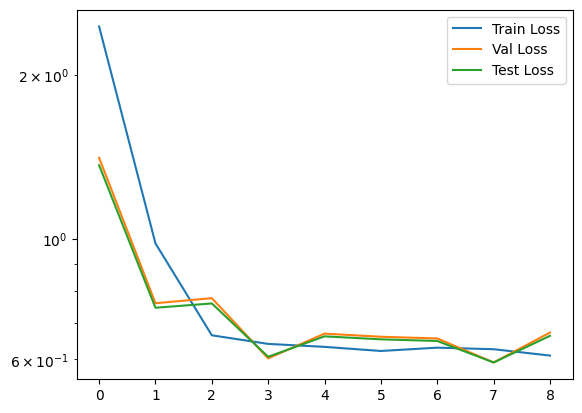

In [ ]:
import matplotlib.pyplot as plt

model = Net(regr=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
max_epoch = 10
best_val_loss = test_loss = None
best_model = None
loss_hist = []
val_hist = []
test_hist = []
for epoch in range(1, max_epoch):
    train_loss = train(epoch)
    val_loss = test(val_loader)
    test_loss = test(test_loader)
    loss_hist.append(train_loss)
    val_hist.append(val_loss)
    test_hist.append(test_loss)
    if best_model is None or best_val_loss > test_loss:
        best_val_loss = test_loss
        best_model = model
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')

plt.plot(loss_hist, label="Train Loss")
plt.plot(val_hist, label="Val Loss")
plt.plot(test_hist, label="Test Loss")
plt.yscale('log')
plt.legend()
plt.show()

このコードは、**グラフニューラルネットワーク（GNN）モデルの訓練・評価を行い、損失の推移をプロットする処理** です。  
`Net` クラスの GNN モデルを訓練し、各エポックの **訓練損失・検証損失・テスト損失を記録＆可視化** しています。

---

## **🔹 コードの解説**
### **1️⃣ 必要なライブラリをインポート**
```python
import matplotlib.pyplot as plt
```
- `matplotlib.pyplot` を使って **学習過程の損失をプロット** する。

---

### **2️⃣ モデル・オプティマイザの定義**
```python
model = Net(regr=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
```
- `Net(regr=True)` で GNN モデルを作成し、`device`（GPU or CPU）へ転送。
- **オプティマイザ (`Adam`)** を設定（学習率 `lr=0.001`）。

---

### **3️⃣ 訓練の設定**
```python
max_epoch = 10
best_val_loss = test_loss = None
best_model = None
loss_hist = []
val_hist = []
test_hist = []
```
- **`max_epoch = 10`**  
  - **10エポック** 訓練を行う。
- **`best_val_loss = test_loss = None`**  
  - **最良の検証損失 (`best_val_loss`) と テスト損失 (`test_loss`) を記録するための変数**。
- **`best_model = None`**  
  - **最良のモデルの保存用変数**。
- **リスト (`loss_hist, val_hist, test_hist`)**  
  - 各エポックの **損失値を記録するリスト**。

---

### **4️⃣ 訓練ループ**
```python
for epoch in range(1, max_epoch):
    train_loss = train(epoch)
    val_loss = test(val_loader)
    test_loss = test(test_loader)

    loss_hist.append(train_loss)
    val_hist.append(val_loss)
    test_hist.append(test_loss)
```
- **`train(epoch)` でモデルを訓練し、`train_loss` を計算**
- **`test(val_loader)` で検証損失 (`val_loss`) を計算**
- **`test(test_loader)` でテスト損失 (`test_loss`) を計算**
- それぞれの損失を **リストに保存**。

---

### **5️⃣ 最良のモデルの保存**
```python
if best_model is None or best_val_loss > test_loss:
    best_val_loss = test_loss
    best_model = model
```
- **最初のエポック (`best_model is None`) または `test_loss` が最小なら、モデルを保存**。

---

### **6️⃣ 損失の表示**
```python
print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, '
      f'Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')
```
- **エポック番号・訓練損失・検証損失・テスト損失を表示**。

---

### **7️⃣ 損失を可視化**
```python
plt.plot(loss_hist, label="Train Loss")
plt.plot(val_hist, label="Val Loss")
plt.plot(test_hist, label="Test Loss")
plt.yscale('log')  # 損失のスケールを対数スケールに設定
plt.legend()
plt.show()
```
- `plt.plot()` で **訓練・検証・テスト損失をプロット**。
- `plt.yscale('log')` で **対数スケールにする（損失が大きく減少する場合に見やすくするため）**。
- `plt.legend()` で凡例を追加。

---

## **🔹 まとめ**
✅ **`train()` でモデルを訓練し、`test()` で評価する**  
✅ **各エポックの損失を記録し、最良のモデルを保存する**  
✅ **`matplotlib` を使って損失の変化を可視化する**  

🚀 **このコードを実行することで、GNNモデルの学習の進行状況を確認し、最良のモデルを選択できる！**

In [ ]:
import numpy as np

df = property_df

# 数値カラムのみを処理
df_numeric = df.select_dtypes(include=[np.number])
df_cla = pd.DataFrame(np.where(df_numeric > df_numeric.mean(), 1, 0), columns=df_numeric.columns)

# 文字列カラムをそのまま結合
df_cla = pd.concat([df_cla, df.select_dtypes(exclude=[np.number])], axis=1)

smiles = list(df["Open Babel SMILES"])
ys = list(df_cla["HOMO-LUMO gap"])

max_nodes = 128
dataset = MoleculesDataset(
    smiles,
    ys,
    transform=torch_geometric.transforms.ToDense(max_nodes)
    )

dataset = dataset.shuffle()
n = (len(dataset) + 9) // 10
test_dataset = dataset[:n]
val_dataset = dataset[n:2 * n]
train_dataset = dataset[2 * n:]
test_loader = torch_geometric.loader.DenseDataLoader(test_dataset, batch_size=32)
val_loader = torch_geometric.loader.DenseDataLoader(val_dataset, batch_size=32)
train_loader = torch_geometric.loader.DenseDataLoader(train_dataset, batch_size=32)

このコードは **分子データ (`property_df`) の前処理を行い、GNN（グラフニューラルネットワーク）に入力できる形式へ変換する処理** です。  
主な処理の流れは以下のとおりです。

---

## **🔹 コードの解説**
### **1️⃣ 必要なライブラリをインポート**
```python
import numpy as np
```
- **`numpy` をインポート**（数値計算ライブラリ）。

---

### **2️⃣ `property_df` を処理対象のデータフレームに設定**
```python
df = property_df
```
- `property_df` を `df` に代入。

---

### **3️⃣ 数値データを0/1のクラスに変換**
```python
df_numeric = df.select_dtypes(include=[np.number])
```
- `df_numeric`：**`property_df` の中から数値データ（`int`, `float`）の列のみを抽出**。

```python
df_cla = pd.DataFrame(np.where(df_numeric > df_numeric.mean(), 1, 0), columns=df_numeric.columns)
```
- `np.where(df_numeric > df_numeric.mean(), 1, 0)`  
  - **各数値カラムの平均値 (`mean()`) を基準に 0/1 に変換**
  - **値が平均より大きければ `1`、小さければ `0`**  
  - 例: `[4, 10, 2]` → 平均 `5.33` → `[0, 1, 0]`
- **結果を `df_cla`（分類データのDataFrame）に格納**。

---

### **4️⃣ 文字列カラムをそのまま結合**
```python
df_cla = pd.concat([df_cla, df.select_dtypes(exclude=[np.number])], axis=1)
```
- `df.select_dtypes(exclude=[np.number])` で **数値以外（例: 文字列）の列を抽出**。
- `df_cla` と結合（数値カラムは `0/1` に変換、文字列カラムはそのまま）。

---

### **5️⃣ SMILES 文字列とターゲット変数 (`HOMO-LUMO gap`) を取得**
```python
smiles = list(df["Open Babel SMILES"])
ys = list(df_cla["HOMO-LUMO gap"])
```
- `smiles`: **分子構造を表す SMILES 記法のリスト**。
- `ys`: **ターゲット変数 `HOMO-LUMO gap` を `0/1` に変換したもの**。

---

### **6️⃣ データセットを `MoleculesDataset` に変換**
```python
max_nodes = 128
dataset = MoleculesDataset(
    smiles,
    ys,
    transform=torch_geometric.transforms.ToDense(max_nodes)
)
```
- `MoleculesDataset` クラスを使用して **分子データをグラフデータに変換**。
- `max_nodes = 128`: **最大ノード数（分子の原子数の上限）**。
- `ToDense(max_nodes)`: **スパースなグラフを密な行列に変換**（バッチ処理のため）。

---

### **7️⃣ データセットをシャッフル**
```python
dataset = dataset.shuffle()
```
- **データセットの順番をランダム化**（訓練時の偏りを防ぐ）。

---

### **8️⃣ 訓練・検証・テストデータに分割**
```python
n = (len(dataset) + 9) // 10
test_dataset = dataset[:n]
val_dataset = dataset[n:2 * n]
train_dataset = dataset[2 * n:]
```
- **データを `8:1:1` の割合で `train/val/test` に分割**（およそ 80% 訓練、10% 検証、10% テスト）。

---

### **9️⃣ データローダーの作成**
```python
test_loader = torch_geometric.loader.DenseDataLoader(test_dataset, batch_size=32)
val_loader = torch_geometric.loader.DenseDataLoader(val_dataset, batch_size=32)
train_loader = torch_geometric.loader.DenseDataLoader(train_dataset, batch_size=32)
```
- **`DenseDataLoader` を使い、GNN のミニバッチ学習を可能にする**。
- **バッチサイズ `32`** でデータを小分けにする。

---

## **🔹 まとめ**
✅ **数値カラムを 0/1 のクラス分類データに変換**  
✅ **SMILES（分子表記）と `HOMO-LUMO gap` を取得**  
✅ **データセットを GNN 用に変換し、訓練・検証・テストに分割**  
✅ **データローダーを作成し、バッチ学習を可能にする**

💡 **このコードにより、分子のグラフデータを GNN に入力する準備が整う！** 🚀

In [ ]:
def train(epoch):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output, _, _ = model(data.x, data.adj.sum(axis=3), data.mask)
        #loss = torch.nn.functional.nll_loss(output, data.y.view(-1))
        loss = torch.nn.functional.nll_loss(output, data.y.long().view(-1))
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.adj.sum(axis=3), data.mask)[0].max(dim=1)[1]
        correct += pred.eq(data.y.view(-1)).sum().item()
    return correct / len(loader.dataset)

このコードは、**GNN（グラフニューラルネットワーク）モデルの学習 (`train` 関数) と評価 (`test` 関数) を行う処理** です。  
**分類タスク** を対象としており、`nll_loss`（負の対数尤度損失）を用いた学習と、**正解率（accuracy）を評価** しています。

---

## **🔹 コードの解説**
### **1️⃣ `train(epoch)`：モデルの学習**
```python
def train(epoch):
    model.train()  # モデルを訓練モードに設定
    loss_all = 0  # 損失の累積
```
- `model.train()` で **モデルを学習モードに設定**（Batch Normalization や Dropout の挙動が変わる）。
- `loss_all` は **エポックごとの総損失を記録**。

---

### **2️⃣ 訓練データでのミニバッチ学習**
```python
for data in train_loader:
    data = data.to(device)  # GPU または CPU にデータを送る
    optimizer.zero_grad()   # 勾配をリセット
```
- `train_loader` から **ミニバッチ単位でデータを取得** し、GPU（またはCPU）に送る。
- `optimizer.zero_grad()` で **前のバッチの勾配をリセット**（累積を防ぐため）。

---

### **3️⃣ モデルの順伝播（フォワードパス）**
```python
output, _, _ = model(data.x, data.adj.sum(axis=3), data.mask)
```
- `model(data.x, data.adj.sum(axis=3), data.mask)` で **GNN のフォワードパスを計算**。
- **`output` はクラスごとのスコア（log-softmax された対数確率）**。

---

### **4️⃣ 損失の計算**
```python
loss = torch.nn.functional.nll_loss(output, data.y.long().view(-1))
```
- **`nll_loss`（負の対数尤度損失）** を計算（分類問題の損失関数）。
- `data.y.long().view(-1)`:  
  - `data.y` を整数 (`long`) に変換
  - `.view(-1)`: **(batch_size, 1) → (batch_size,) に変換**（nll_loss の入力形式に適合）

---

### **5️⃣ 誤差逆伝播とパラメータ更新**
```python
loss.backward()  # 逆伝播
loss_all += data.y.size(0) * loss.item()  # バッチの損失を累積
optimizer.step()  # パラメータ更新
```
- `loss.backward()` で **誤差を逆伝播**。
- `loss_all` に **ミニバッチの損失を累積**（`data.y.size(0)` はサンプル数）。
- `optimizer.step()` で **パラメータを更新**。

---

### **6️⃣ エポックごとの平均損失を返す**
```python
return loss_all / len(train_dataset)
```
- **データセット全体の平均損失を計算し、返す**。

---

---

## **🔹 `test(loader)`: モデルの評価**
```python
@torch.no_grad()
def test(loader):
    model.eval()  # モデルを評価モードに設定
    correct = 0  # 正解数のカウント
```
- `@torch.no_grad()`: **勾配計算を無効化**（メモリ消費削減 & 推論の高速化）。
- `model.eval()`: **モデルを評価モードに設定**（Dropout や Batch Normalization の影響をなくす）。
- `correct = 0`: **正解数をカウントする変数**。

---

### **1️⃣ 推論（フォワードパス）**
```python
for data in loader:
    data = data.to(device)
    pred = model(data.x, data.adj.sum(axis=3), data.mask)[0].max(dim=1)[1]
```
- ミニバッチ単位でデータを取得し、GPU（またはCPU）に送る。
- `model(data.x, data.adj.sum(axis=3), data.mask)[0]`:  
  - モデルの出力（log-softmax された対数確率）。
- `.max(dim=1)[1]`:  
  - **最も確率の高いクラスのインデックスを取得**（分類タスクの予測結果）。

---

### **2️⃣ 予測と正解を比較**
```python
correct += pred.eq(data.y.view(-1)).sum().item()
```
- `.eq(data.y.view(-1))`: **予測 `pred` と正解ラベル `data.y` を比較**（`True/False`）。
- `.sum().item()`: **正解した数を整数でカウントし、`correct` に加算**。

---

### **3️⃣ 正解率（Accuracy）を計算**
```python
return correct / len(loader.dataset)
```
- **全データに対する正解の割合（Accuracy）を返す**。

---

## **🔹 まとめ**
✅ **`train(epoch)`: GNN の学習（損失 `nll_loss` を計算し、誤差逆伝播で最適化）**  
✅ **`test(loader)`: GNN の評価（予測結果の正解率を計算）**  

💡 **このコードにより、GNN を用いた分類タスクの学習・評価が可能になる！** 🚀

Epoch: 001, Train Loss: 0.4699, Val Acc: 0.8221, Test Acc: 0.8176
Epoch: 002, Train Loss: 0.3696, Val Acc: 0.8267, Test Acc: 0.8221
Epoch: 004, Train Loss: 0.3565, Val Acc: 0.8267, Test Acc: 0.8255
Epoch: 005, Train Loss: 0.3530, Val Acc: 0.8267, Test Acc: 0.8301
Epoch: 006, Train Loss: 0.3505, Val Acc: 0.8290, Test Acc: 0.8324
Epoch: 007, Train Loss: 0.3481, Val Acc: 0.8335, Test Acc: 0.8358
Epoch: 009, Train Loss: 0.3450, Val Acc: 0.8358, Test Acc: 0.8392


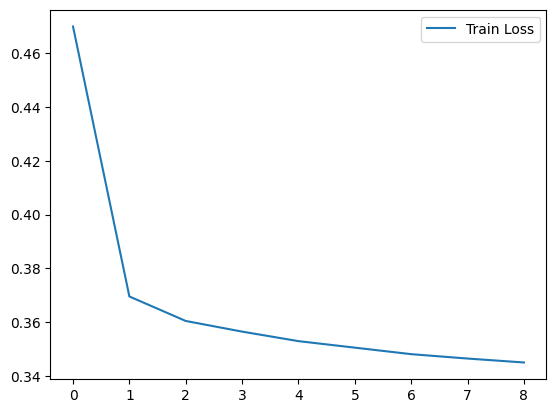

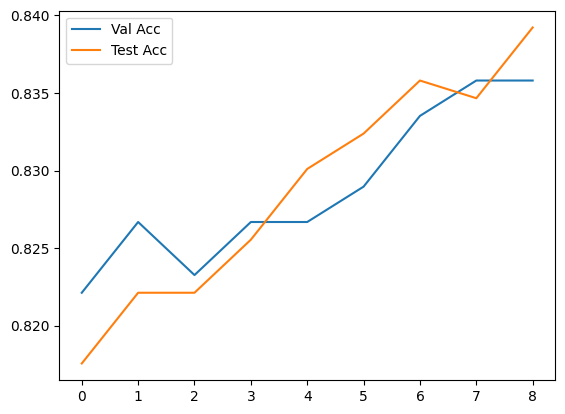

In [ ]:
import matplotlib.pyplot as plt

model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
max_epoch = 10
best_val_acc = test_acc = 0
best_model = None
loss_hist = []
val_hist = []
test_hist = []
for epoch in range(1, max_epoch):
    train_loss = train(epoch)
    val_acc = test(val_loader)
    test_acc = test(test_loader)
    loss_hist.append(train_loss)
    val_hist.append(val_acc)
    test_hist.append(test_acc)
    if best_model is None or best_val_acc < test_acc:
        best_val_acc = test_acc
        best_model = model
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

plt.plot(loss_hist, label="Train Loss")
plt.legend()
plt.show()
plt.plot(val_hist, label="Val Acc")
plt.plot(test_hist, label="Test Acc")
plt.legend()
plt.show()

このコードは、**GNN（グラフニューラルネットワーク）モデルの学習と評価** を行い、その結果を **可視化** するものです。  
具体的には、以下の処理を行っています。

---

## **🔹 コードの解説**
### **1️⃣ 必要なライブラリをインポート**
```python
import matplotlib.pyplot as plt
```
- `matplotlib.pyplot` を使って **学習過程の可視化** を行う。

---

### **2️⃣ モデルとオプティマイザの準備**
```python
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
```
- `Net()`（定義済みの GNN モデル）を `device`（GPU または CPU）に配置。
- `torch.optim.Adam` を使って **モデルのパラメータを最適化**。
- 学習率 (`lr=0.001`) を設定。

---

### **3️⃣ 変数の初期化**
```python
max_epoch = 10
best_val_acc = test_acc = 0
best_model = None
loss_hist = []
val_hist = []
test_hist = []
```
- `max_epoch = 10`: **最大エポック数を 10 に設定**。
- `best_val_acc = test_acc = 0`: **最良の検証精度・テスト精度を保持する変数を初期化**。
- `best_model = None`: **最良モデルを格納する変数**。
- `loss_hist`, `val_hist`, `test_hist`: **学習損失・精度を記録するリスト**。

---

### **4️⃣ 学習ループ**
```python
for epoch in range(1, max_epoch):
    train_loss = train(epoch)  # 1エポック分の学習
    val_acc = test(val_loader)  # 検証データで評価
    test_acc = test(test_loader)  # テストデータで評価
```
- `train(epoch)`: **1エポック分の学習を行い、損失を計算**。
- `test(val_loader)`: **検証データで評価（精度を計算）**。
- `test(test_loader)`: **テストデータで評価（精度を計算）**。

---

### **5️⃣ 結果を記録**
```python
loss_hist.append(train_loss)
val_hist.append(val_acc)
test_hist.append(test_acc)
```
- 各エポックの **学習損失・検証精度・テスト精度をリストに保存**。

---

### **6️⃣ 最良モデルの更新**
```python
if best_model is None or best_val_acc < test_acc:
    best_val_acc = test_acc
    best_model = model
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
```
- **テスト精度が過去最高なら `best_model` を更新**。
- `print()` でエポックごとの損失・精度を出力。

---

### **7️⃣ 学習曲線のプロット**
```python
plt.plot(loss_hist, label="Train Loss")
plt.legend()
plt.show()
```
- **学習損失をプロット**（横軸：エポック、縦軸：損失）。

```python
plt.plot(val_hist, label="Val Acc")
plt.plot(test_hist, label="Test Acc")
plt.legend()
plt.show()
```
- **検証精度・テスト精度をプロット**（横軸：エポック、縦軸：精度）。

---

## **🔹 まとめ**
✅ **GNN の学習 (`train()`) と評価 (`test()`) を繰り返す**  
✅ **最良のテスト精度 `best_model` を保持**  
✅ **学習損失・精度の推移を可視化**  

💡 **学習過程の可視化により、過学習や収束状況が確認できる！** 🚀